In [1]:
from scipy.io import loadmat
from scipy.stats import circmean, circstd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

from utils import validate_data

## Loading all the data

In [2]:
# Set in stone
data_path = '../axej/'
n_subjects = 13
n_sessions = 4
n_runs = 6
n_trials = 120
n_ts = 500

exp_ts = 1000

# noise frames = 0 to 220 (250 - 30)
noise_thresh = 0.5
noise_gap = 30


experiment_orientations = [159, 123, 87, 51, 15]
subjects = ["01", "02", "03", "04", "05", "06", "07", "08" ,"09", "10", "11", "12", "14"]

def get_calib(subj, sess):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Cali1.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

def get_run(subj, sess, run):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Run{run+1}.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

In [37]:
# Get all run data
# subjexts x sessions x runs
jx = []
jy = []
stimdir = []
tgonset = []

# Attention (attCue): tr_foc = 1, tr_div = 2
# Coherence (tgCoh): tr_lo = 1, tr_hi = 2
# ExpOrientation (expOri): 1,2,3,4,5 -> 159, 123, 87, 51, 15
att = []
coh = []
exp = []

for subj in tqdm(range(n_subjects)):
    for sess in range(n_sessions):
        for run in range(n_runs):

            data = get_run(subj, sess, run)
            jx.append(data["joyx"])
            jy.append(data["joyy"])
            stimdir.append(data["stimDirREAL"])

            f_tgonset = data["f_precuedur"] + data["f_cuedur"]
            tgonset.append(f_tgonset)

            att.append(data["attCue"])
            coh.append(data["tgCoh"])

            try:
                # print(data["expOri"])
                exp.append([experiment_orientations[data["expOri"] - 1]]*n_trials)
            except:
                # print("No expOri")
                exp.append([np.nan]*n_trials)
                

# Shape the run data
jx = np.array(jx, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
jy = np.array(jy, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
stimdir = np.array(stimdir).reshape(n_subjects, n_sessions, n_runs, n_trials)
tgonset = np.array(tgonset).reshape(n_subjects, n_sessions, n_runs, n_trials)
att = np.array(att, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials)
coh = np.array(coh, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials)
exp = np.array(exp, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials)

jx.shape, jy.shape, stimdir.shape, tgonset.shape, att.shape, coh.shape, exp.shape

100%|██████████| 13/13 [00:01<00:00,  9.41it/s]


((13, 4, 6, 120, 500),
 (13, 4, 6, 120, 500),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120))

## Logic for Getting Valid Trials:

1. Get all the trials
2. Align all target onset at 250 ts
3. Get distance from center and angle from center
4. If the distance moves <0.4 au n frames before target onset. Then that trial is "too early" and all response set nan.
5. If ts has distance > 1 au then set its response angle to the last valid angle (if first, the nan) and set that distance to 1.
6. get angle first distance = 1 a.u. instance after target onset. or if it never reaches 1, then angle at max distance after target onset. as the response angle.

In [25]:
shifted_jx, shifted_jy, dist_from_cent, resp_angle, final_resp_angles = validate_data(n_subjects, n_sessions, n_runs, n_trials, n_ts, exp_ts, jx, jy, tgonset, noise_thresh, noise_gap)

In [26]:
# Get all trials where angles are only nan
nan_trials = np.where(np.isnan(resp_angle).all(axis=-1))
print(nan_trials[0].shape[0], "removed trials")
print(nan_trials[0].shape[0] / (n_subjects * n_sessions * n_runs * n_trials) * 100, "% removed trials")

2919 removed trials
7.7964743589743595 % removed trials


In [35]:
exp.shape

(13, 4, 6, 120)

In [ ]:
exp[0,0, :5, :]

## Circular stat defs

In [42]:
def circdist(a, b):
    return min(abs(a-b), 360-abs(a-b))

def circmedian(angs):
    angs = np.array(angs)
    angs = angs[~np.isnan(angs)]
    pdists = angs[np.newaxis, :] - angs[:, np.newaxis]
    pdists = (pdists + 180) % (2 * 180) - 180
    pdists = np.abs(pdists).sum(1)
    return angs[np.argmin(pdists)]

In [43]:
calib_median = np.load("../cache/calib_results/circ_median.npy")
median_key = {15:0, 51:1, 87:2, 123:3, 159:4}

In [44]:
calib_std = np.load("../cache/calib_results/circ_std.npy")
std_key = {15:0, 51:1, 87:2, 123:3, 159:4}

## Design Matrix

Things that are considered as u_t

- Calibrated stimulus (median)
- Coherece
- Attention 

compared:

- bias

In [45]:
final_resp_angles.shape, stimdir.shape

((13, 4, 6, 120), (13, 4, 6, 120))

#### calib stimdir:

- Some representations go below the horizon.
- So rotating 90 deg counterclockwise before scaling to 0-1 range:
    - target
    - observation

##### Rotate by 90 deg counterclockwise:

In [10]:
# Rotate all angles by 90 deg counter-clockwise
target = (calib_median + 90) % 360
observation = (final_resp_angles + 90) % 360

Text(0, 0.5, 'jy')

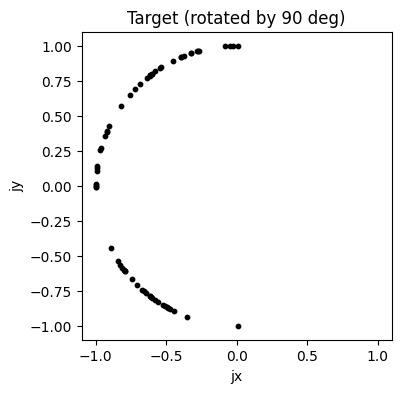

In [11]:
# Scatter plot on a cricumference of a circle with radius 1
# based on the angle provided from the right horizontal axis as 0 and going counter-clockwise to 360
# angles will be given in degrees

x = np.cos(np.deg2rad(target))
y = np.sin(np.deg2rad(target))

plt.figure(figsize=(4,4))
plt.scatter(x, y, s=10, c="k", label="Target")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.title("Target (rotated by 90 deg)")
plt.xlabel("jx")
plt.ylabel("jy")



Text(0, 0.5, 'jy')

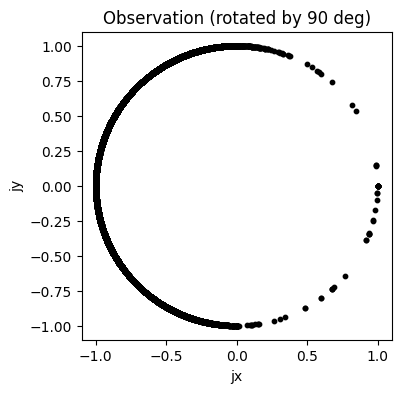

In [12]:
x = np.cos(np.deg2rad(observation))
y = np.sin(np.deg2rad(observation))

plt.figure(figsize=(4,4))
plt.scatter(x, y, s=10, c="k", label="Target")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.title("Observation (rotated by 90 deg)")
plt.xlabel("jx")
plt.ylabel("jy")

##### Scale to 0-1 range:

In [13]:
# Rotate all angles by 90 deg counter-clockwise
target = (calib_median + 90) % 360
observation = (final_resp_angles + 90) % 360

# Scale everything to be between 0 and 1
target = target / 360
observation = observation / 360

In [14]:
observation.shape

(13, 4, 6, 120)

In [15]:
stimulus = np.zeros((n_subjects, n_sessions, n_runs, n_trials))

for subj in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                target_key = median_key[stimdir[subj, sess, run, trial]]
                stimulus[subj, sess, run, trial] = target[subj, target_key]

#### Attention + Coherence:

In [16]:
# Coherence (tgCoh): tr_lo = 1, tr_hi = 2
# coh = []

# Attention (attCue): tr_foc = 1, tr_div = 2
# att = []

In [17]:
att.shape, coh.shape

((13, 4, 6, 120), (13, 4, 6, 120))

In [18]:
coh[coh == 2] = 1
coh[coh == 1] = -1

att[att == 1] = 1
att[att == 2] = -1

## Cache it

In [19]:
stimulus.shape, att.shape, coh.shape, observation.shape

((13, 4, 6, 120), (13, 4, 6, 120), (13, 4, 6, 120), (13, 4, 6, 120))

In [20]:
# Total non nan responses
len(observation.flatten()) - np.unique(observation, return_counts= 1)[1][-1]

34521

In [21]:
# Drop all "too early" trials:

# valid_stimulus = stimulus[~np.isnan(observation)]
# valid_att = att[~np.isnan(observation)]
# valid_coh = coh[~np.isnan(observation)]

# valid_stimulus.shape, valid_att.shape, valid_coh.shape

In [22]:
# check if there are any nan values
tot_nan = 0
for session in observation.reshape(-1, 120):
    if np.isnan(session).any():
        tot_nan += 1

f"{tot_nan}/312 trials contain nan values"

'209/312 trials contain nan values'

In [23]:
# setting all observation with nan to -1 (no response)

valid_observation = observation.reshape(-1, 120, 1)
valid_observation[np.isnan(valid_observation)] = -1

valid_stimulus = stimulus.reshape(-1, 120)
valid_coh = coh.reshape(-1, 120)
valid_att = att.reshape(-1, 120)

In [24]:
valid_design_matrix = np.stack([valid_stimulus, valid_coh, valid_att], axis=-1)
valid_design_matrix.shape

(312, 120, 3)

In [25]:
valid_observation.shape

(312, 120, 1)

In [28]:
# np.save("../cache/data_prep/observation.npy", valid_observation)
# np.save("../cache/data_prep/design_matrix.npy", valid_design_matrix)